In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
weather_df = pd.read_csv("Chicago Weather Data 2011-2015.txt")
weather_df.rename(columns={'CST':'Date'}, inplace=True)
weather_df['Date'] = pd.to_datetime(weather_df['Date']).dt.date

crime_df = pd.read_csv("Chicago Crime 2011-2015.csv")

In [3]:
# This one takes a while...
crime_df['Date'] = pd.to_datetime(crime_df['Date']).dt.date

In [4]:
newcols = []
for i in weather_df.columns:
    if i[0] == ' ':
        i = i[1:]
    newcols.append(i)
weather_df.columns = newcols
weather_df['Clear'] = weather_df['CloudCover'].map(lambda x: int(x) < 3)

In [5]:
# Mapping function so that temps can be categorized into buckets
def temp_map(temp):
    if temp < 0:
        return 'below 0'
    else:
        return str((temp//10)*10) + 's'

In [6]:
weather_df['temp bucket'] = weather_df['Max TemperatureF'].map(temp_map)

In [7]:
# Create a list of each unique weather event type
eventlist = list(weather_df['Events'].unique())
neweventlist = []
for i in eventlist:
    i = str(i)
    neweventlist.append(i.split('-'))
eventlist = []
for i in neweventlist:
    for j in i:
        if j != 'nan':
            eventlist.append(j)
eventlist = list(set(eventlist))

In [8]:
# Create a new column in the weather dataframe for each item in the event list and populate with True or False for each day
for e in eventlist:
    weather_df[e] = weather_df['Events'].map(lambda x: e in str(x))

In [9]:
dailycounts = crime_df.groupby('Date').size()
weather_df['crimes'] = weather_df.Date.map(lambda x: dailycounts[x])
def get_local_avg(date,span=7,df=weather_df):
    return df[(df['Date'] < date + datetime.timedelta(days=span/2)) & 
              (df['Date'] > date - datetime.timedelta(days=span/2)) &
              (df['Date'] != date)]['crimes'].mean()

weather_df['localavg'] = weather_df.Date.map(get_local_avg)
weather_df['localdeviation'] = weather_df['crimes']/weather_df['localavg'] - 1
weather_df['day'] = weather_df.Date.map(lambda x: x.day)

In [10]:
# Left-join dataframes (crime on the left)
combined = pd.merge(crime_df, weather_df, how='left', on='Date')
combined.head()

,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,District,FBI Code,Max TemperatureF,...,temp bucket,Rain,Hail,Fog,Thunderstorm,Snow,crimes,localavg,localdeviation,day
0,2015-12-31,025XX W 63RD ST,DECEPTIVE PRACTICE,"THEFT BY LESSEE,MOTOR VEH",OTHER,False,False,8,11,28,...,20s,False,False,False,False,True,593,597.5,-0.007531,31
1,2015-12-31,075XX S EMERALD AVE,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,6,14,28,...,20s,False,False,False,False,True,593,597.5,-0.007531,31
2,2015-12-31,015XX N KEDZIE AVE,THEFT,FROM BUILDING,RESIDENCE PORCH/HALLWAY,False,False,14,06,28,...,20s,False,False,False,False,True,593,597.5,-0.007531,31
3,2015-12-31,079XX S STONY ISLAND AVE,BATTERY,AGGRAVATED: OTHER DANG WEAPON,STREET,False,False,4,04B,28,...,20s,False,False,False,False,True,593,597.5,-0.007531,31
4,2015-12-31,037XX N CLARK ST,BATTERY,SIMPLE,SIDEWALK,True,False,19,08B,28,...,20s,False,False,False,False,True,593,597.5,-0.007531,31


In [11]:
days = len(weather_df)
# Can filter by simply calling the column, since each of the event columns contains a True or a False
daycounts = {
    'Thunderstorm': len(weather_df[weather_df['Thunderstorm']]),
    'Hail': len(weather_df[weather_df['Hail']]),
    'Snow': len(weather_df[weather_df['Snow']]),
    'Rain': len(weather_df[weather_df['Rain']]),
    'Fog': len(weather_df[weather_df['Fog']]),
    'Clear': len(weather_df[weather_df['Clear']])
    }
print(days)
print(daycounts)

1826
{'Hail': 3, 'Fog': 93, 'Thunderstorm': 191, 'Rain': 608, 'Clear': 293, 'Snow': 273}


In [12]:
# Plucking out the frequency of each primary crime type (rate) for the presence or absense of each event type
# No special reason to run count() on dates, it's just one option that works
freq_no_thunder = combined[combined['Thunderstorm'] == False].groupby('Primary Type')['Date'].count()/(days - daycounts['Thunderstorm'])
freq_yes_thunder = combined[combined['Thunderstorm'] == True].groupby('Primary Type')['Date'].count()/daycounts['Thunderstorm']

freq_no_hail = combined[combined['Hail'] == False].groupby('Primary Type')['Date'].count()/(days - daycounts['Hail'])
freq_yes_hail = combined[combined['Hail'] == True].groupby('Primary Type')['Date'].count()/daycounts['Hail']

freq_no_snow = combined[combined['Snow'] == False].groupby('Primary Type')['Date'].count()/(days - daycounts['Snow'])
freq_yes_snow = combined[combined['Snow'] == True].groupby('Primary Type')['Date'].count()/daycounts['Snow']

freq_no_rain = combined[combined['Rain'] == False].groupby('Primary Type')['Date'].count()/(days - daycounts['Rain'])
freq_yes_rain = combined[combined['Rain'] == True].groupby('Primary Type')['Date'].count()/daycounts['Rain']

freq_no_fog = combined[combined['Fog'] == False].groupby('Primary Type')['Date'].count()/(days - daycounts['Fog'])
freq_yes_fog = combined[combined['Fog'] == True].groupby('Primary Type')['Date'].count()/daycounts['Fog']

freq_not_clear = combined[combined['Clear'] == False].groupby('Primary Type')['Date'].count()/(days - daycounts['Clear'])
freq_clear = combined[combined['Clear'] == True].groupby('Primary Type')['Date'].count()/(daycounts['Clear'])

In [13]:
# Constructing a dataframe to capture the "effect" of an event, which I am defining to be the crime rate
# during an event divided by the crime rate in the absense of that event.
thunder_comparison = pd.concat([freq_no_thunder, freq_yes_thunder],axis=1)
thunder_comparison.columns=['no thunder','thunder']
thunder_comparison['thunder effect'] = (thunder_comparison['thunder'] / thunder_comparison['no thunder']) - 1

hail_comparison = pd.concat([freq_no_hail, freq_yes_hail],axis=1)
hail_comparison.columns=['no hail','hail']
hail_comparison['hail effect'] = (hail_comparison['hail'] / hail_comparison['no hail']) - 1

snow_comparison = pd.concat([freq_no_snow, freq_yes_snow],axis=1)
snow_comparison.columns=['no snow','snow']
snow_comparison['snow effect'] = (snow_comparison['snow'] / snow_comparison['no snow']) - 1

rain_comparison = pd.concat([freq_no_rain, freq_yes_rain],axis=1)
rain_comparison.columns=['no rain','rain']
rain_comparison['rain effect'] = (rain_comparison['rain'] / rain_comparison['no rain']) - 1

fog_comparison = pd.concat([freq_no_fog, freq_yes_fog],axis=1)
fog_comparison.columns=['no fog','fog']
fog_comparison['fog effect'] = (fog_comparison['fog'] / fog_comparison['no fog']) - 1

clear_comparison = pd.concat([freq_not_clear, freq_clear],axis=1)
clear_comparison.columns=['not clear','clear']
clear_comparison['clear effect'] = (clear_comparison['clear'] / clear_comparison['not clear']) - 1

In [14]:
# Putting it all together
# hail_comparison['hail effect'] removed because there are only 3 days with hail - too insignificant
comparison_df = pd.concat([thunder_comparison['thunder effect'], clear_comparison['clear effect'], 
                          rain_comparison['rain effect'], fog_comparison['fog effect'],
                          snow_comparison['snow effect']], axis = 1)

In [15]:
# Building a dictionary to capture the 'sample size' for each primary type to help restrict findings
# to those that are significant
primary_types = list(combined['Primary Type'].unique())
type_counts = {}
for i in primary_types:
    type_counts[i] = len(combined[combined['Primary Type'] == i])

In [16]:
# Add the sample size values from above into its own column so it can be sorted in descending order
# (Most frequent crime on top)
comparison_df['sample size'] = comparison_df.index.map(lambda x: type_counts[x])
comparison_df.sort_values(by='sample size', ascending=[1], inplace=True)

In [17]:
# Just naming the index column so that it auto-populates the axis label in the plot
comparison_df.index.names = ['Primary Type']

In [18]:
# New instance of the comparison DF ommitting anything with a 'small' sample size
comparison_df_truncated = comparison_df[comparison_df['sample size'] > 1000]

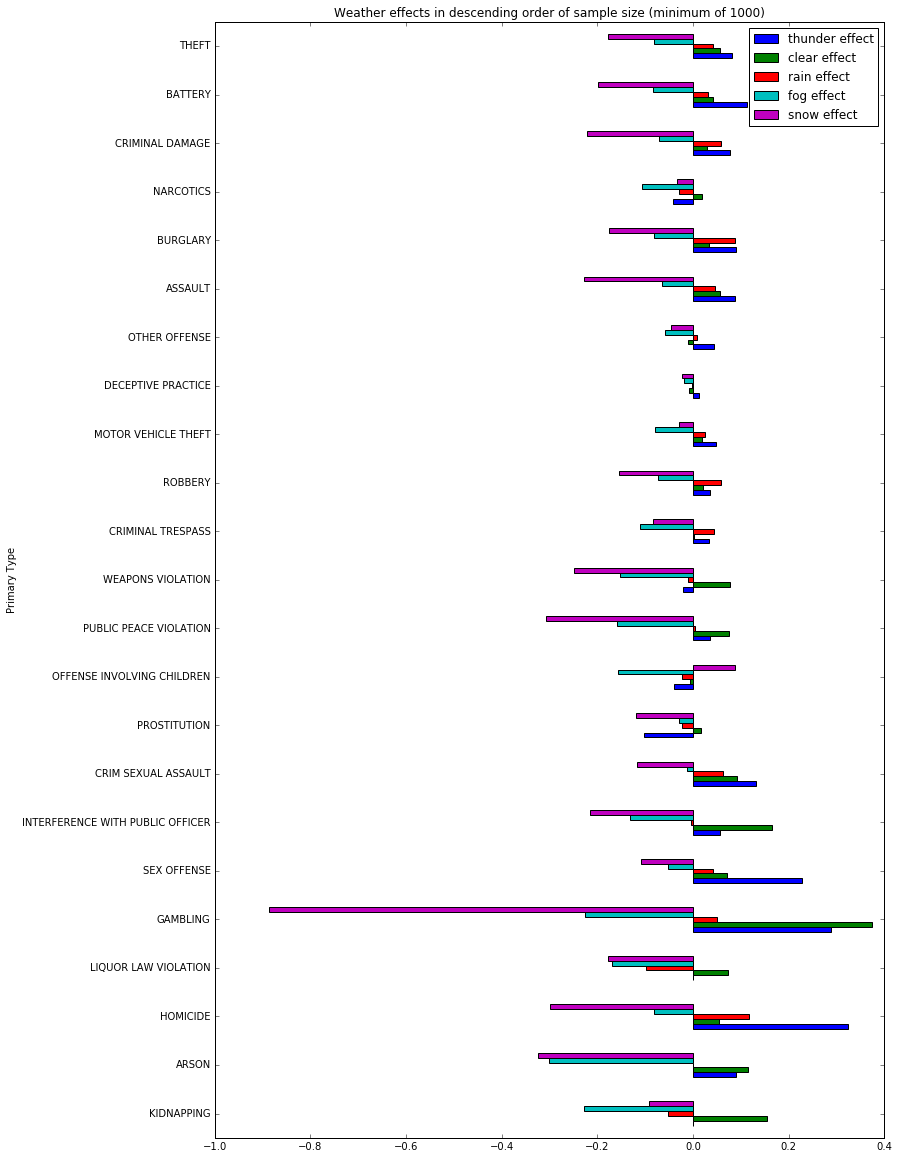

In [19]:
columns = [column for column in comparison_df_truncated.columns if column != 'sample size']
comparison_df_truncated[columns].plot(kind='barh', figsize=(12,20), 
                                      title='Weather effects in descending order of sample size (minimum of 1000)')

In [20]:
overall_no_thunder = combined[combined['Thunderstorm'] == False]['Date'].count()/(days - daycounts['Thunderstorm'])
overall_yes_thunder = combined[combined['Thunderstorm'] == True]['Date'].count()/daycounts['Thunderstorm']

print(overall_yes_thunder/overall_no_thunder)

1.0621336307


In [21]:
comparison_list = [thunder_comparison, rain_comparison, snow_comparison, fog_comparison, clear_comparison]

In [22]:
for df in comparison_list:
    print(str(df.columns[1]) + ': ' + str("{0:.2f}%".format(df[df.columns[1]].sum()/df[df.columns[0]].sum() - 1)))

thunder: 0.06%
rain: 0.03%
snow: -0.15%
fog: -0.08%
clear: 0.04%


## What's up with the thunderstorm spike?

In [23]:
print('Average high temp on thunderstorm days',combined[combined['Thunderstorm'] == True]['Max TemperatureF'].mean())
print('Average high temp on non-thunderstorm days',combined[combined['Thunderstorm'] == False]['Max TemperatureF'].mean())

Average high temp on thunderstorm days 77.46127988047809
Average high temp on non-thunderstorm days 59.31813009092962


## Perhaps Temp is the larger driving force...

In [24]:
combined.groupby(['temp bucket'])['Date'].count()

temp bucket
0s           4376
100s         4019
10s         27914
20s         82158
30s        169849
40s        194796
50s        202668
60s        206374
70s        242881
80s        303228
90s         89449
below 0       363
Name: Date, dtype: int64

In [25]:
buckets = list(combined['temp bucket'].unique())
print(buckets)

['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '10s', '0s', 'below 0', '100s']


In [26]:
temp_factors = []
overall = len(combined)/len(weather_df)
for bucket in buckets:
    temp_factors.append([bucket, (len(combined[combined['temp bucket'] == bucket])/
                         len(weather_df[weather_df['temp bucket'] == bucket]))/overall])
print(temp_factors)

[['20s', 0.839112323742332], ['30s', 0.8980709693308097], ['40s', 0.9739535309726317], ['50s', 0.9925478617021362], ['60s', 1.019050528517014], ['70s', 1.0402684850108632], ['80s', 1.0947057780030787], ['90s', 1.1876516677664526], ['10s', 0.7412516328641519], ['0s', 0.6536472359013792], ['below 0', 0.4337732113934198], ['100s', 1.200643620241153]]


In [27]:
temp_bucket_df_index = ['below 0', '0s', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '100s']
temp_bucket_df_columns = ['Day Count', 'Crime Rate']
temp_bucket_df = pd.DataFrame(index=temp_bucket_df_index, columns=temp_bucket_df_columns)

def daycount(bucket,event='',col='temp bucket',df=weather_df):
    if event == '':
        return len(df[df[col] == bucket])
    else:
        return len(df[(df[col] == bucket) & (df[event])])
    
def crimerate(bucket,event='',days_func=daycount,col='temp bucket',df=combined):
    if days_func(bucket,event) == 0:
        return np.nan
    if event == '':
        return len(df[df[col] == bucket]) / days_func(bucket)
    else:
        return len(df[(df[col] == bucket) & (df[event])]) / days_func(bucket,event)

temp_bucket_df['Day Count'] = temp_bucket_df.index.map(daycount)
temp_bucket_df['Crime Rate'] = temp_bucket_df.index.map(crimerate)
temp_bucket_df['Clear Days'] = temp_bucket_df.index.map(lambda x: daycount(x,'Clear'))
temp_bucket_df['Clear Rate'] = temp_bucket_df.index.map(lambda x: crimerate(x,'Clear'))

for event in eventlist:
    temp_bucket_df[str(event) + ' Days'] = temp_bucket_df.index.map(lambda x: daycount(x,event))
    temp_bucket_df[str(event) + ' Rate'] = temp_bucket_df.index.map(lambda x: crimerate(x,event))

In [28]:
temp_bucket_df['Clear Effect'] = ((temp_bucket_df['Clear Rate'] / temp_bucket_df['Crime Rate'])-1)*100
for event in eventlist:
    temp_bucket_df[str(event) + ' Effect'] = ((temp_bucket_df[str(event) + ' Rate'] / temp_bucket_df['Crime Rate'])-1)*100
temp_bucket_df['Temp Effect'] = ((temp_bucket_df['Crime Rate'] / overall)-1)*100
temp_bucket_df

,Day Count,Crime Rate,Clear Days,Clear Rate,Rain Days,Rain Rate,Hail Days,Hail Rate,Fog Days,Fog Rate,...,Thunderstorm Rate,Snow Days,Snow Rate,Clear Effect,Rain Effect,Hail Effect,Fog Effect,Thunderstorm Effect,Snow Effect,Temp Effect
below 0,1,363.000000,1,363.000000,0,NaN,0,NaN,0,NaN,...,NaN,0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,-56.622679
0s,8,547.000000,4,513.250000,0,NaN,0,NaN,0,NaN,...,NaN,2,509.000000,-6.170018,NaN,NaN,NaN,NaN,-6.946984,-34.635276
10s,45,620.311111,13,619.384615,0,NaN,0,NaN,2,554.000000,...,NaN,27,613.518519,-0.149360,NaN,NaN,-10.689976,NaN,-1.095030,-25.874837
20s,117,702.205128,15,746.333333,0,NaN,0,NaN,8,679.000000,...,693.000000,81,692.148148,6.284233,NaN,NaN,-3.304608,-1.310889,-1.432200,-16.088768
30s,226,751.544248,16,762.250000,30,740.133333,0,NaN,19,672.842105,...,755.750000,117,739.641026,1.424501,-1.518329,NaN,-10.472057,0.559615,-1.583835,-10.192903
40s,239,815.046025,14,844.214286,99,828.171717,0,NaN,14,731.500000,...,790.000000,41,840.170732,3.578726,1.610423,NaN,-10.250467,-3.072958,3.082612,-2.604647
50s,244,830.606557,41,812.536585,94,818.734043,0,NaN,13,766.307692,...,839.900000,4,778.000000,-2.175515,-1.429379,NaN,-7.741194,1.118874,-6.333511,-0.745214
60s,242,852.785124,37,855.972973,118,845.966102,0,NaN,9,876.444444,...,874.304348,1,682.000000,0.373816,-0.799618,NaN,2.774359,2.523405,-20.026748,1.905053
70s,279,870.541219,49,884.408163,106,861.179245,0,NaN,12,835.416667,...,863.594595,0,NaN,1.592911,-1.075420,NaN,-4.034795,-0.797966,NaN,4.026849
80s,331,916.096677,75,934.080000,129,898.054264,3,891.666667,16,900.250000,...,895.432099,0,NaN,1.963038,-1.969488,-2.66675,-1.729804,-2.255720,NaN,9.470578


In [29]:
print(plt.style.available)

['ggplot', 'seaborn-talk', 'grayscale', 'fivethirtyeight', 'classic', 'seaborn-muted', 'seaborn-whitegrid', 'seaborn-notebook', 'dark_background', 'seaborn-ticks', 'bmh', 'seaborn-dark', 'seaborn-poster', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-paper', 'seaborn-white', 'seaborn-bright', 'seaborn-dark-palette', 'seaborn-colorblind', 'seaborn-pastel']


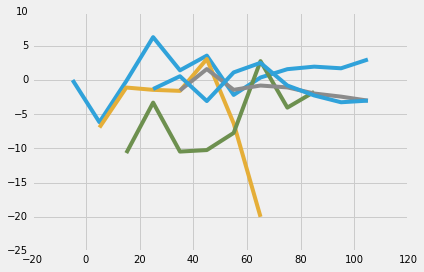

In [30]:

x = list(range(-5,106,10))

with plt.style.context('fivethirtyeight'):
    plt.plot(x, list(temp_bucket_df['Clear Effect']))
    plt.plot(x, list(temp_bucket_df['Hail Effect']))
    plt.plot(x, list(temp_bucket_df['Snow Effect']))
    plt.plot(x, list(temp_bucket_df['Fog Effect']))
    plt.plot(x, list(temp_bucket_df['Rain Effect']))
    plt.plot(x, list(temp_bucket_df['Thunderstorm Effect']))

plt.show()

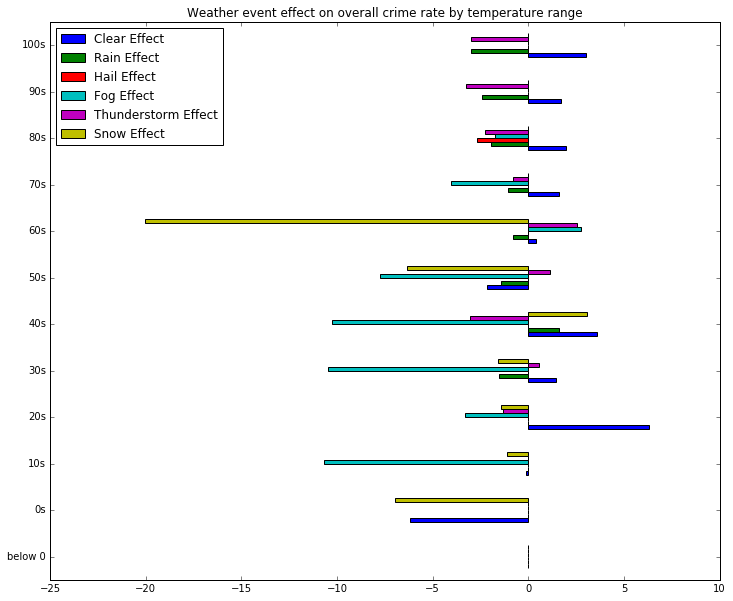

In [31]:
temp_bucket_df[(['Clear Effect'] + 
                [i + ' Effect' for i in eventlist])].plot(kind = 'barh', figsize = (12,10),
                                                     title = 'Weather event effect on overall crime rate by temperature range')

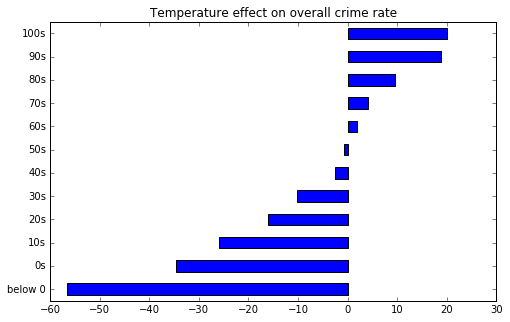

In [32]:
temp_bucket_df['Temp Effect'].plot(kind = 'barh', figsize = (8,5), title='Temperature effect on overall crime rate')

In [33]:
typelist = sorted(list(combined['Primary Type'].unique()))

temp_crime_df = pd.DataFrame(index=temp_bucket_df_index[2:len(temp_bucket_df_index)-1],columns=['Days', 'Overall'] + typelist)

combined[combined['Primary Type'] == typelist[0]].describe()

temp_crime_df['Days'] = temp_crime_df.index.map(lambda x: weather_df[weather_df['temp bucket'] == x]['Date'].count())
temp_crime_df['Overall'] = temp_crime_df.index.map(lambda x: combined[combined['temp bucket'] == x]['Date'].count())

for i in typelist:
    temp_crime_df[i] = temp_crime_df.index.map(lambda x: combined[(combined['temp bucket'] == x) & (combined['Primary Type'] == i)]['Date'].count())

temp_crime_df

,Days,Overall,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL TRESPASS,...,OTHER NARCOTIC VIOLATION,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
10s,45,27914,35,1661,4572,1543,0,117,2489,780,...,2,2042,187,0,207,995,75,15,6047,250
20s,117,82158,99,4358,14003,4988,2,363,7797,2289,...,1,5514,479,3,636,3087,281,47,17690,869
30s,226,169849,209,9495,28782,10333,1,718,16898,4615,...,0,10821,1059,5,1376,6456,476,93,36718,1731
40s,239,194796,258,10969,32287,12640,4,845,20517,5067,...,3,11832,1263,8,1738,7621,654,116,43228,2094
50s,244,202668,308,12023,34921,13079,10,859,22179,5195,...,6,12007,1243,8,1967,7935,561,111,44956,2344
60s,242,206374,301,12883,36915,12877,5,936,22648,5170,...,2,11880,1084,7,2083,7961,668,103,45556,2403
70s,279,242881,348,15440,44077,14926,15,1010,25657,6220,...,7,13736,1477,14,2547,9267,789,137,55741,3011
80s,331,303228,474,19297,57922,18211,10,1398,31823,7295,...,7,16956,1833,11,3118,11593,1089,157,68559,3629
90s,90,89449,148,5559,16871,5944,2,402,9608,2082,...,3,4629,553,7,841,3509,325,49,20358,1072


In [34]:
for i in typelist:
    temp_crime_df[i.lower() + ' rate'] = (temp_crime_df[i]/temp_crime_df['Days']) - (temp_crime_df[i].sum()/temp_crime_df['Days'].sum())

rate_columns = [i.lower() + ' rate' for i in typelist]


In [35]:
temp_crime_df['DECEPTIVE PRACTICE']

10s     1728
20s     4285
30s     8239
40s     9233
50s     9355
60s     9458
70s    10524
80s    12234
90s     3353
Name: DECEPTIVE PRACTICE, dtype: int64

In [36]:
len(combined[combined['Primary Type'] == 'DECEPTIVE PRACTICE'])

68864

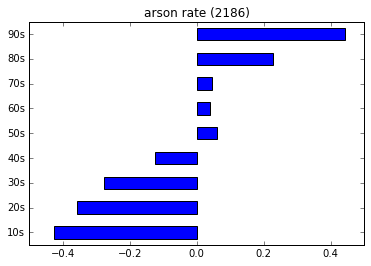

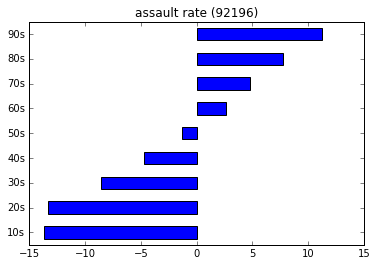

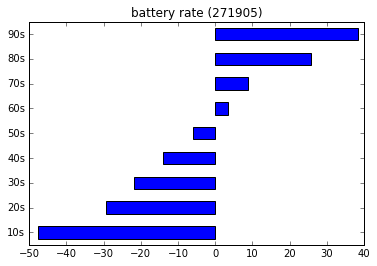

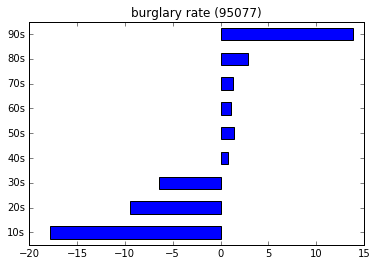

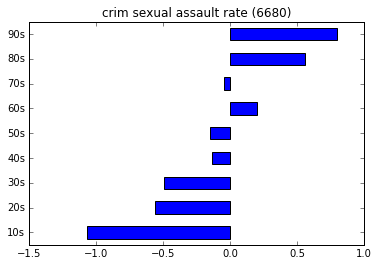

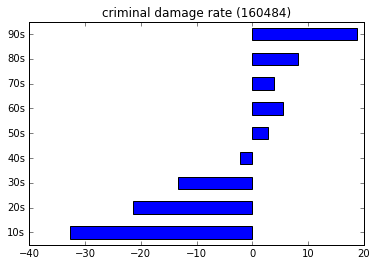

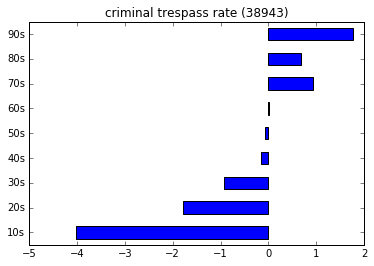

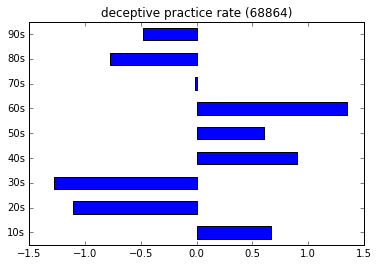

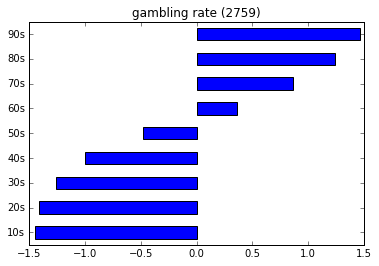

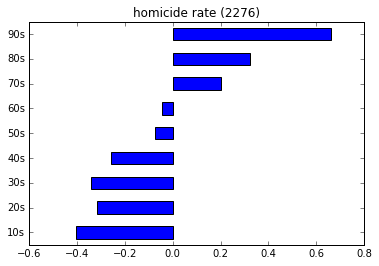

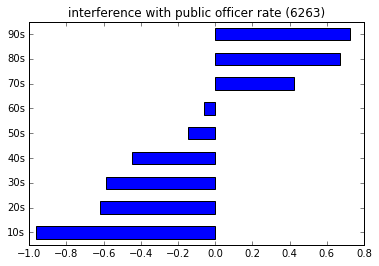

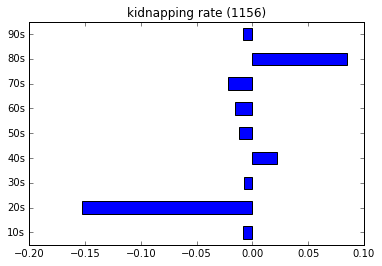

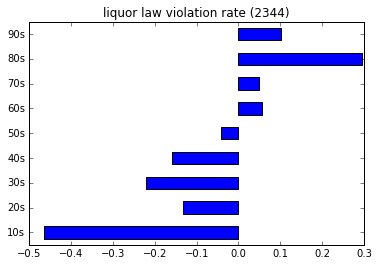

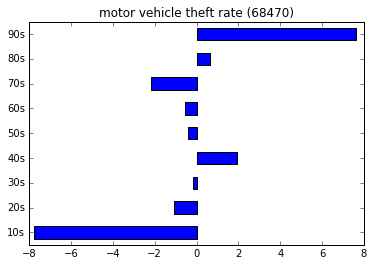

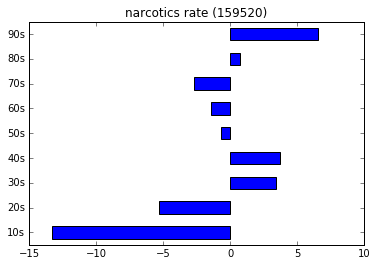

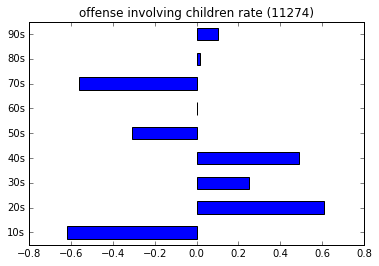

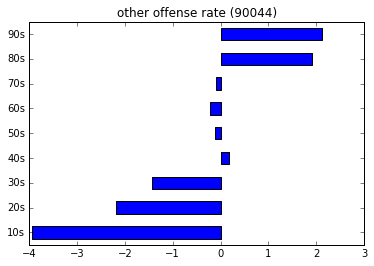

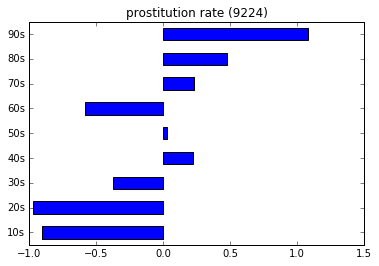

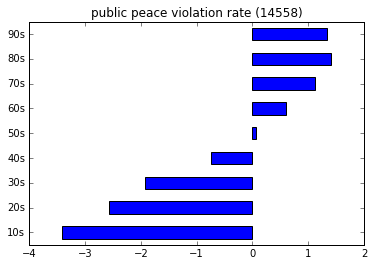

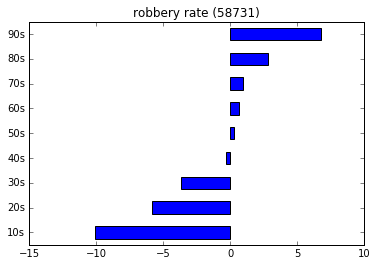

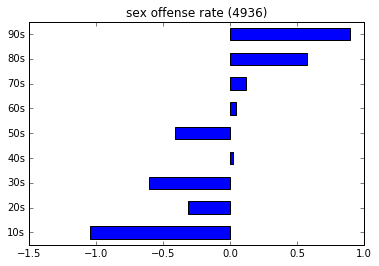

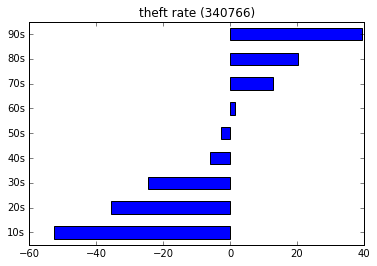

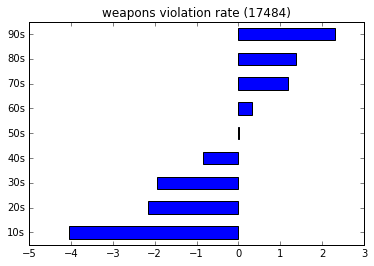

In [37]:
for i in rate_columns:
    test = i[:len(i)-5].upper()
    count = len(combined[combined['Primary Type'] == test])
    if count > 1000:
        temp_crime_df[i].plot(kind='barh',title=i + ' (' + str(count) + ')')
        plt.show()

Thunderstorm
False    Axes(0.125,0.125;0.775x0.775)
True     Axes(0.125,0.125;0.775x0.775)
Name: Mean Wind SpeedMPH, dtype: object

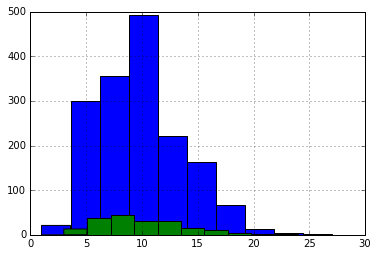

In [38]:
weather_df.groupby(['Thunderstorm'])['Mean Wind SpeedMPH'].hist()

In [41]:
combined.columns

Index(['Date', 'Block', 'Primary Type', 'Description', 'Location Description',
       'Arrest', 'Domestic', 'District', 'FBI Code', 'Max TemperatureF',
       'Mean TemperatureF', 'Min TemperatureF', 'Max Dew PointF',
       'MeanDew PointF', 'Min DewpointF', 'Max Humidity', 'Mean Humidity',
       'Min Humidity', 'Max Sea Level PressureIn', 'Mean Sea Level PressureIn',
       'Min Sea Level PressureIn', 'Max VisibilityMiles',
       'Mean VisibilityMiles', 'Min VisibilityMiles', 'Max Wind SpeedMPH',
       'Mean Wind SpeedMPH', 'Max Gust SpeedMPH', 'PrecipitationIn',
       'CloudCover', 'Events', 'WindDirDegrees', 'Clear', 'temp bucket',
       'Rain', 'Hail', 'Fog', 'Thunderstorm', 'Snow', 'crimes', 'localavg',
       'localdeviation', 'day'],
      dtype='object')

In [80]:
types_df = pd.DataFrame(index=primary_types)
types_df['total'] = types_df.index.map(lambda x: len(combined[combined['Primary Type'] == x]))
types_df.sort_values(by='total', ascending=[0], inplace=True)

In [85]:
types_df.drop(types_df[types_df['total'] < 1000].index, axis=0, inplace=True)

In [90]:
# Pull crime rate for a given primary type and day of the month
def inclusivedayrate(ptype, day=1, df=combined):
    instances = len(df[(df['Primary Type'] == ptype) & (df['day'] == day)])
    days = len(df[(df['Primary Type'] == ptype) & (df['day'] == day)].Date.unique())
    return instances/days

def exclusivedayrate(ptype, day=1, df=combined):
    instances = len(df[(df['Primary Type'] == ptype) & (df['day'] != day)])
    days = len(df[(df['Primary Type'] == ptype) & (df['day'] != day)].Date.unique())
    return instances/days

In [92]:
types_df['firstrate'] = types_df.index.map(inclusivedayrate)
types_df['otherdaysrate'] = types_df.index.map(exclusivedayrate)
types_df['firstratefactor'] = types_df['firstrate'] / types_df['otherdaysrate']

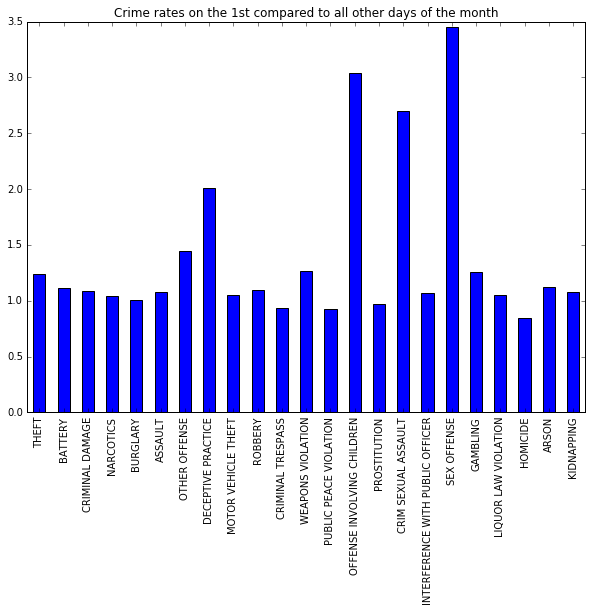

In [98]:
types_df.firstratefactor.plot(kind='bar', title='Crime rates on the 1st compared to all other days of the month', figsize=(10,7))

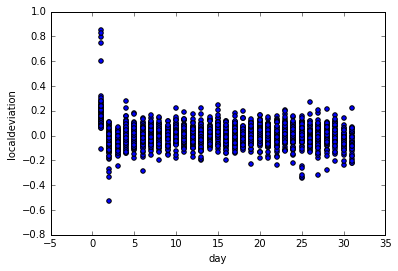

In [55]:
weather_df.plot(x='day', y='localdeviation', kind='scatter')